In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils import data
from torch.utils.data import random_split,DataLoader
import string
from PIL import Image
import matplotlib.pyplot as plt
import time
import shutil
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torch.nn.parallel import DataParallel

In [45]:
USE_CUDA = torch.cuda.is_available()

print("Device : {0}".format("GPU" if USE_CUDA else "CPU"))
device = torch.device("cuda" if USE_CUDA else "cpu")
cpu_device = torch.device("cpu")

BATCH_SIZE=128
VAL_SPLIT=0.2

AFFN_KERNEL=5
AFFN_STRIDE=1
AFFN_DEPTH=2

CRNN_KERNEL=5
CRNN_POOL_KERNEL=2
CRNN_DROPOUT=0.3
CRNN_LATENT=128
LSTM_HIDDEN_DIM=32
VOCAB_SIZE=26+10
OUTPUT_LENGTH=6

SAVE_EPOCH=10
VAL_EPOCH=1
EPOCHS= 130
epoch_count = [i for i in range(1,EPOCHS+1)]

train_acc=[]
test_acc=[]

Device : GPU


In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available. Using GPU(s):", torch.cuda.device_count())
else:
    device = torch.device('cpu')
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU(s): 1


In [9]:
data = '/kaggle/input/captchaimgdata/trainset'

In [10]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image
import string
import zipfile

def get_dataloaders(data_dir, batch_size=32, val_split=0.2, shuffle=True, num_workers=0):
    # Define the character set (vocabulary)
    characters = string.ascii_uppercase + string.digits  # Uppercase + lowercase + digits
    char_to_idx = {char: idx for idx, char in enumerate(characters)}
    vocab_size = len(characters)

    class CustomDataset(Dataset):
        def __init__(self, root_dir, transform=None):
            self.root_dir = root_dir
            self.transform = transform
            self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('png', 'jpg', 'jpeg'))]
            self.labels = [os.path.basename(f).split('.')[0].upper() for f in self.image_paths]  # Extract filename as label

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('RGB')
            label_str = self.labels[idx]

            # Convert label string to one-hot encoded tensor
            label_indices = [char_to_idx[c] for c in label_str if c in char_to_idx]  # Map characters to indices
            label_tensor = torch.zeros(len(label_indices),dtype=torch.long)  # One-hot encoding tensor
            for i, index in enumerate(label_indices):
                label_tensor[i] = index  # Set one-hot encoding

            if self.transform:
                image = self.transform(image)

            return image, label_tensor

    transform = transforms.Compose([
        transforms.Resize((64,192)),  # Resize to a fixed size
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.Lambda(lambda x: x / 255),
    ])

    dataset = CustomDataset(root_dir=data_dir, transform=transform)
    print(f"Dataset size: {len(dataset)}")  # Print dataset size

    # Compute train-validation split
    total_size = len(dataset)
    val_size = int(total_size * val_split)
    train_size = total_size - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader


In [11]:
train_loader,val_loader=get_dataloaders(data_dir= data, batch_size=BATCH_SIZE, val_split=0.2, shuffle=True)

Dataset size: 26155


In [12]:
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([128, 1, 64, 192]), torch.Size([128, 6]))

In [13]:
#def accuracy_fn(y_true, y_pred):
        #correct = torch.eq(y_true, y_pred).sum().item()
        #acc = (correct / len(y_true))
        #return acc
def accuracy_fn(y_true, y_pred):
            y_true = y_true.cpu()  
            y_pred = y_pred.cpu()

            y_true = y_true.view(-1)  
            y_pred = y_pred.view(-1)  

            correct = torch.eq(y_true, y_pred).sum().item()
            total_samples = len(y_true) 

            acc = (correct / total_samples)*100
            return acc

In [14]:
class Encoder(nn.Sequential):
    def __init__(self,n,kernel_size,stride):
        super().__init__(
            nn.Conv2d(in_channels=4**(n-1),out_channels=4**n,kernel_size=kernel_size,stride=stride),
            nn.BatchNorm2d(num_features=4**n),
            nn.ReLU(inplace=False)
        )
class Decoder(nn.Sequential):
    def __init__(self,n,kernel_size,stride):
        super().__init__(
            nn.ConvTranspose2d(in_channels=4**n,out_channels=4**(n-1),kernel_size=kernel_size,stride=stride),
            nn.BatchNorm2d(num_features=4**(n-1)),
            nn.ReLU(inplace=False)
        )

In [46]:
class AFFN(nn.Module):
    def __init__(self,n):
        super().__init__()
        self.n=n
        self.alpha=nn.Parameter(torch.randn(n-1).to(device)).to(device)

        #During training, the values of alpha are adjusted by the optimizer to learn the optimal feature fusion strategy. If alpha[i] is close to 0,
        #the network emphasizes the direct path.
        #If alpha[i] is close to 1, it emphasizes the residual path.
        self.encoders=[]
        for i in range(1,n+1):
            self.encoders.append(Encoder(i,AFFN_KERNEL,AFFN_STRIDE).to(device))

        self.decoders=[]
        for i in range(n,0,-1):
            self.decoders.append(Decoder(i,AFFN_KERNEL,AFFN_STRIDE).to(device))

    def forward(self, x):
        residuals = []
        for i, enc in enumerate(self.encoders):
            x = enc(x)
            if i < self.n - 1:
                x = x * (1 - self.alpha[i])
                residuals.append(x * self.alpha[i])

        for i, dec in enumerate(self.decoders):
            x = dec(x)
            if i < self.n - 1:
                x = x + residuals.pop()

        return x

In [28]:
class CRNN(nn.Module):
    def __init__(self, in_channels, kernel_size, pool_kernel_size, dropout, latent_dim, lstm_hidden_dim, vocab_size, output_length=5):
        super().__init__()
        self.lstm_hidden_dim = lstm_hidden_dim
        self.output_length = output_length  
        self.vocab_size = vocab_size

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels*2, kernel_size=kernel_size, padding=2),
            nn.BatchNorm2d(num_features=in_channels*2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=pool_kernel_size)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels*2, out_channels=in_channels*4, kernel_size=kernel_size, padding=2),
            nn.BatchNorm2d(num_features=in_channels*4),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=pool_kernel_size)
        )
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout)
        self.latent_fc = nn.LazyLinear(latent_dim)
        self.lstm = nn.LSTM(input_size=latent_dim, hidden_size=lstm_hidden_dim, num_layers=1, batch_first=True)
        self.output_fc = nn.Linear(lstm_hidden_dim, vocab_size)

    def forward(self, x):
        batch_size = x.size(0)

        conv1_out = self.conv1(x)
        conv2_out = self.conv2(conv1_out)
        flattened = self.flatten(conv2_out)
        dropped = self.dropout(flattened)
        latent = self.latent_fc(dropped)

        lstm_input = latent.unsqueeze(1)

        h0 = torch.zeros(1, batch_size, self.lstm_hidden_dim).to(x.device)
        c0 = torch.zeros(1, batch_size, self.lstm_hidden_dim).to(x.device)

        outputs = []

        for _ in range(self.output_length):
            out, (h0, c0) = self.lstm(lstm_input, (h0, c0))  # out shape: (batch_size, 1, lstm_hidden_dim)

            logits = self.output_fc(out.squeeze(1))  # Shape: (batch_size, vocab_size)

            outputs.append(logits)

        outputs = torch.stack(outputs, dim=1)  # Shape: (batch_size, 6, vocab_size)

        return outputs


In [47]:
class CaptchaCrackNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.affn=AFFN(AFFN_DEPTH).to(device)

        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=5,padding=2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2)
        ).to(device)

        self.conv2=nn.Sequential(
                    nn.Conv2d(in_channels=32,out_channels=48,kernel_size=5,padding=2),
                    nn.ReLU(inplace=False),
                    nn.MaxPool2d(kernel_size=2)
                ).to(device)

        self.conv3=nn.Sequential(
            nn.Conv2d(in_channels=48,out_channels=64,kernel_size=5,padding=2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2)
        ).to(device)

        self.res=nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=2, padding=2).to(device)

        self.crnn=CRNN(64,CRNN_KERNEL,CRNN_POOL_KERNEL,CRNN_DROPOUT,CRNN_LATENT,LSTM_HIDDEN_DIM,VOCAB_SIZE,OUTPUT_LENGTH).to(device)

    def forward(self,x):
        affn_out=self.affn(x)
        res_out=self.res(x)
        conv1_out=self.conv1(affn_out)
        conv2_out=self.conv2(conv1_out+res_out)
        conv3_out=self.conv3(conv2_out)
        output=self.crnn(conv3_out)
        return output


In [48]:
def train(model,train_loader,val_loader,epochs=EPOCHS):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)
    model.to(device)
    train_history=[]
    val_history=[]
    train_acc=[]
    val_acc=[]
    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}:")
        avg_acc=0
        avg_loss=0
        model.train()
        for batch_num,(X,y) in enumerate(tqdm(train_loader,desc="Progress: ")):

            X=X.to(device)
            y=y.to(device)
            optimizer.zero_grad()
            preds=model(X).to(device)

            loss=loss_fn(preds.view(-1, VOCAB_SIZE),y.view(-1))
            loss.backward()
            optimizer.step()

            avg_loss+=loss.item()
            avg_acc+=accuracy_fn(y_true=y.cpu(),y_pred=torch.argmax(preds,dim=2).cpu())


        avg_loss/=len(train_loader)
        avg_acc/=len(train_loader)
        train_acc.append(avg_acc)
        print(f"Train Acc: {avg_acc}%")
        train_history.append(avg_loss)
        print(f"Train Loss: {avg_loss}")

        eval_loss=0
        eval_acc=0
        if VAL_EPOCH and epoch%VAL_EPOCH==0:
            model.eval()
            with torch.no_grad():
                for batch_num,(X,y) in enumerate(tqdm(val_loader,desc="Progress: ")):
                    X=X.to(device)
                    y=y.to(device)
                    preds=model(X).to(device)
                    loss=loss_fn(preds.view(-1, VOCAB_SIZE),y.view(-1))
                    eval_acc+=accuracy_fn(y_true=y,y_pred=torch.argmax(preds,dim=2))
                    eval_loss+=loss.item()
                eval_acc/=len(val_loader)
                val_acc.append(eval_acc)
                print(f"Val Acc: {eval_acc}%")
                eval_loss/=len(val_loader)
                val_history.append(eval_loss)
                print(f"Val Loss: {eval_loss}")


        if SAVE_EPOCH and epoch%SAVE_EPOCH==0:
            print("Saving model")
            path=str(epoch)+'.pth'
            torch.save(model.state_dict(), path)
    torch.save(model.state_dict(),'final.pth')

    return train_history,val_history,train_acc,val_acc




In [49]:
model=CaptchaCrackNet().to(device)

In [ ]:
# 1. Instantiate the model
loaded_model = CaptchaCrackNet() 

# 2. Load the state dictionary
#Replace 'final.pth' or '10.pth' with your actual saved file name
state_dict = torch.load('final.pth', map_location=torch.device('cpu')) # you may need map_location=torch.device('cpu')

# 3. Load the state dictionary into the model
loaded_model.load_state_dict(state_dict) 

# Set the model to evaluation mode
loaded_model.eval()

In [40]:
train_history,val_history,train_acc,val_acc =train(model,train_loader,val_loader,EPOCHS)

Epoch 1:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 10.434557079945797%
Train Loss: 3.276441475240196


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 10.592652484801876%
Val Loss: 3.260162655900164
Epoch 2:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 12.124248390921407%
Train Loss: 3.2526657261499543


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 13.207262140188973%
Val Loss: 3.234447950270118
Epoch 3:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 13.98321053523035%
Train Loss: 3.2204961311526414


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 10.37715497509705%
Val Loss: 3.3196116482339253
Epoch 4:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 15.02069571476965%
Train Loss: 3.172063391383101


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 14.487572557313415%
Val Loss: 3.159174855162458
Epoch 5:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 15.623623814363139%
Train Loss: 3.1232229631121564


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 15.60202542481506%
Val Loss: 3.11589006679814
Epoch 6:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 16.834614244579942%
Train Loss: 3.076432168483734


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 15.111748562586973%
Val Loss: 3.1203450400654864
Epoch 7:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 17.97578971883469%
Train Loss: 3.0257543761555743


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 16.7553319325423%
Val Loss: 3.107455509464915
Epoch 8:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 19.102038871951216%
Train Loss: 2.968935226521841


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 19.377780982201713%
Val Loss: 2.956546475247639
Epoch 9:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 19.656324102303522%
Train Loss: 2.9184563189018062


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 12.285332207207206%
Val Loss: 3.229170287527689
Epoch 10:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 19.549457994579956%
Train Loss: 2.9050148216689506


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 20.160976525305788%
Val Loss: 2.863533921358062
Saving model
Epoch 11:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 21.369145918021673%
Train Loss: 2.7979835184609017


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 20.905575926536287%
Val Loss: 2.804352614937759
Epoch 12:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 22.24207105352305%
Train Loss: 2.7439192591643913


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 22.25772838387168%
Val Loss: 2.736897927958791
Epoch 13:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 22.97441353319783%
Train Loss: 2.703657446838007


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 22.636851790815207%
Val Loss: 2.718320369720459
Epoch 14:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 24.359914888211385%
Train Loss: 2.641506042422318


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 25.44106606606607%
Val Loss: 2.601201807580343
Epoch 15:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 26.479664210704584%
Train Loss: 2.5389563150522187


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 27.935996209624253%
Val Loss: 2.484809357945512
Epoch 16:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 29.608263465447163%
Train Loss: 2.430022954940796


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 30.822753012158493%
Val Loss: 2.371364959856359
Epoch 17:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 32.99754403794039%
Train Loss: 2.307696726264023


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 35.41346224273054%
Val Loss: 2.2298916432915665
Epoch 18:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 36.16335323509486%
Train Loss: 2.18683895977532


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 38.74849506518715%
Val Loss: 2.1024093976834926
Epoch 19:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 39.40432334010841%
Train Loss: 2.0715141972390616


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 41.192612200615244%
Val Loss: 2.0118758940115207
Epoch 20:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 42.53747459349592%
Train Loss: 1.9597865503008773


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 44.62097387021167%
Val Loss: 1.883082735829237
Saving model
Epoch 21:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 45.11528201219513%
Train Loss: 1.849820695999192


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 47.07069874752803%
Val Loss: 1.7750589760338389
Epoch 22:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 47.54514947493225%
Train Loss: 1.7509008086309201


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 49.22046665568007%
Val Loss: 1.69946313776621
Epoch 23:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 49.688717394986455%
Train Loss: 1.659563726768261


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 51.10515431590126%
Val Loss: 1.5984783812267025
Epoch 24:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 51.948837652439%
Train Loss: 1.5733490390021627


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 54.116511709880605%
Val Loss: 1.5048753924486113
Epoch 25:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 54.058265582655814%
Train Loss: 1.4956519807257302


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 55.38512025745258%
Val Loss: 1.4346040690817483
Epoch 26:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 55.758860518292686%
Train Loss: 1.4255280392925913


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 56.8745479473376%
Val Loss: 1.3806138358465054
Epoch 27:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 57.61866954607048%
Train Loss: 1.3575043809123155


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 59.03922214897823%
Val Loss: 1.3199877273745653
Epoch 28:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 59.60842225609757%
Train Loss: 1.2926240948642171


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 60.41575111697063%
Val Loss: 1.255275778654145
Epoch 29:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 61.485116023035204%
Train Loss: 1.230284728655001


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 63.434919294294296%
Val Loss: 1.165786574526531
Epoch 30:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 63.40346587059619%
Train Loss: 1.1694911274968125


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 62.845934730462155%
Val Loss: 1.1572529484586018
Saving model
Epoch 31:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 65.36834137872624%
Train Loss: 1.111898175100001


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 66.26330980370616%
Val Loss: 1.066294681735155
Epoch 32:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 67.2727705792683%
Train Loss: 1.0543026048235777


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 68.29385597487733%
Val Loss: 1.0109585218313264
Epoch 33:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 69.10907859078594%
Train Loss: 1.0026908466001836


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 70.48779915586317%
Val Loss: 0.9649896738005848
Epoch 34:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 70.93358316395663%
Train Loss: 0.9533811880321037


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 72.87990162418518%
Val Loss: 0.899039724978005
Epoch 35:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 72.70251100948514%
Train Loss: 0.9061492848687056


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 73.48353498315387%
Val Loss: 0.8679683949889206
Epoch 36:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 74.4947281504065%
Train Loss: 0.8592454652960707


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 76.15190457225519%
Val Loss: 0.8096070871120546
Epoch 37:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 76.23120977303527%
Train Loss: 0.8162426370673064


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 77.53558627224785%
Val Loss: 0.7762945323455624
Epoch 38:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 77.72685890921409%
Train Loss: 0.7744427879409093


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 78.91755131656045%
Val Loss: 0.7347092192347456
Epoch 39:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 79.292323001355%
Train Loss: 0.7340614061530043


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 80.41647783454187%
Val Loss: 0.6990492896335881
Epoch 40:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 80.55873136856368%
Train Loss: 0.7003256889378152


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 81.94990913169266%
Val Loss: 0.6568860818700093
Saving model
Epoch 41:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 81.7914761178862%
Train Loss: 0.6650158130541081


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 83.00230489635977%
Val Loss: 0.6271460187144395
Epoch 42:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 83.29972264566396%
Train Loss: 0.6296263537028941


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 82.70134654471546%
Val Loss: 0.6191932864305449
Epoch 43:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 84.47731410907859%
Train Loss: 0.5977613515243297


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 85.80577528748259%
Val Loss: 0.5612590603712129
Epoch 44:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 85.80633892276427%
Train Loss: 0.56428379765371


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 86.43507264886837%
Val Loss: 0.5331059156394586
Epoch 45:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 86.76411119579949%
Train Loss: 0.5353407283745161


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 87.7652233025709%
Val Loss: 0.501058272472242
Epoch 46:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 87.700129149729%
Train Loss: 0.5102907221128301


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 88.2300936607339%
Val Loss: 0.47840413015063216
Epoch 47:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 88.53542090108401%
Train Loss: 0.4844065386711097


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 89.05823697172784%
Val Loss: 0.4569985452221661
Epoch 48:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 89.64298568766938%
Train Loss: 0.4575486066864758


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 90.04614370468029%
Val Loss: 0.43076132492321295
Epoch 49:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 90.46001651422762%
Train Loss: 0.43384397466008257


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 89.94257214531605%
Val Loss: 0.42014892653721136
Epoch 50:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 91.14149305555556%
Train Loss: 0.41086566211973746


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 91.3914581502234%
Val Loss: 0.39316630145398584
Saving model
Epoch 51:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 91.69704861111114%
Train Loss: 0.3923767897777441


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 91.46913681974655%
Val Loss: 0.3752336414848886
Epoch 52:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 92.51196222899728%
Train Loss: 0.3704016726554894


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 92.18638417380798%
Val Loss: 0.35277256224213577
Epoch 53:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 92.5929983909214%
Train Loss: 0.3603273241258249


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 91.9770094026954%
Val Loss: 0.35215827168487923
Epoch 54:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 93.10059917005421%
Train Loss: 0.34403485023393865


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 92.76998988317587%
Val Loss: 0.3289308373521014
Epoch 55:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 93.81960323509486%
Train Loss: 0.32282174414977793


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 93.23365858236282%
Val Loss: 0.31182095481128225
Epoch 56:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 94.16656080623308%
Train Loss: 0.30992371116469547


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 93.76596489782466%
Val Loss: 0.29564376066370707
Epoch 57:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 94.74551151761517%
Train Loss: 0.2916629236282372


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 94.34150232549622%
Val Loss: 0.2764062230906835
Epoch 58:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 94.97311144986449%
Train Loss: 0.27839500993126776


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 94.43703421409212%
Val Loss: 0.2750171760960323
Epoch 59:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 95.41581978319792%
Train Loss: 0.2630457818144705


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 94.85232183402915%
Val Loss: 0.2550798087585263
Epoch 60:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 95.79225948509485%
Train Loss: 0.2496253679074892


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 95.24391960558118%
Val Loss: 0.24680552540755854
Saving model
Epoch 61:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 95.95856622628722%
Train Loss: 0.24045457872675685


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 95.56296006372224%
Val Loss: 0.23084931475360218
Epoch 62:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 96.27736492208675%
Train Loss: 0.22815328781924596


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 95.63525987878123%
Val Loss: 0.2267283023130603
Epoch 63:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 96.55662474593494%
Train Loss: 0.2176212255002522


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 95.57248750274665%
Val Loss: 0.22139198496574308
Epoch 64:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 96.80444402100268%
Train Loss: 0.20666652608935426


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 96.24990844503041%
Val Loss: 0.20328765780460545
Epoch 65:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 97.05972645663958%
Train Loss: 0.19699276811102542


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 95.72272348568079%
Val Loss: 0.21319502882841157
Epoch 66:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 97.22693301151762%
Train Loss: 0.1882846743413588


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 96.29534259869627%
Val Loss: 0.19030964883362375
Epoch 67:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 97.36947408536584%
Train Loss: 0.1802489459514618


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 96.7660781970995%
Val Loss: 0.17642518296474363
Epoch 68:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 97.62735010162599%
Train Loss: 0.17001115812397585


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 96.52546029260968%
Val Loss: 0.17677423648717927
Epoch 69:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 97.81350567411924%
Train Loss: 0.16107290756048226


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 96.96787107229179%
Val Loss: 0.16313399774272266
Epoch 70:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 98.02263296070457%
Train Loss: 0.15259592135141536


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 96.91119282392145%
Val Loss: 0.15950434164303104
Saving model
Epoch 71:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 98.06391852981031%
Train Loss: 0.14765567291618847


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 96.71844100197761%
Val Loss: 0.16776455393651638
Epoch 72:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 98.21942750677516%
Train Loss: 0.1399897671781662


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 97.48381193693692%
Val Loss: 0.1439645419397005
Epoch 73:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 98.37128429878048%
Train Loss: 0.13285218828880205


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 97.63502069142311%
Val Loss: 0.14195067835290257
Epoch 74:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 98.50900872289976%
Train Loss: 0.12725322234739617


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 97.72394345565078%
Val Loss: 0.1315347557751144
Epoch 75:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 98.53928480691054%
Train Loss: 0.12265330057863782


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 97.66263023694427%
Val Loss: 0.13043946100444329
Epoch 76:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 98.65806021341463%
Train Loss: 0.11647334145154895


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 97.91083003735442%
Val Loss: 0.12259477485970753
Epoch 77:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 98.77995850271006%
Train Loss: 0.1105422323524225


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.07474204387313%
Val Loss: 0.11697143661539729
Epoch 78:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 98.74094893292683%
Train Loss: 0.10722460066218202


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 97.81873146011866%
Val Loss: 0.12016614944469638
Epoch 79:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 98.95335789295393%
Train Loss: 0.10334744717834926


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 97.84828654874383%
Val Loss: 0.11803463810100788
Epoch 80:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.01915015243904%
Train Loss: 0.09812259097106574


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.17270586134916%
Val Loss: 0.10757721651618074
Saving model
Epoch 81:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 98.98082867547429%
Train Loss: 0.09589162487082364


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.19713959386215%
Val Loss: 0.10645825179611765
Epoch 82:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 98.95790989159894%
Train Loss: 0.09457935265651564


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.14804324141215%
Val Loss: 0.10545909513787526
Epoch 83:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 98.96426151761518%
Train Loss: 0.09271159931653883


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.28826539954589%
Val Loss: 0.09894651101856697
Epoch 84:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.10706724254746%
Train Loss: 0.08720955516143543


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.33859202189994%
Val Loss: 0.09714148484352159
Epoch 85:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.12257579607049%
Train Loss: 0.08521951884939903


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.30242780890647%
Val Loss: 0.09565978370061735
Epoch 86:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.10431487127373%
Train Loss: 0.08308163603268019


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.1985987511902%
Val Loss: 0.09703897212336703
Epoch 87:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.20424712059625%
Train Loss: 0.07971083356930715


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.43727111257596%
Val Loss: 0.08799702183502477
Epoch 88:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.28353658536584%
Train Loss: 0.07483174308861901


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.52888330403574%
Val Loss: 0.08531899495822627
Epoch 89:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.2973513719512%
Train Loss: 0.07295023288759517


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.63417151908006%
Val Loss: 0.08284011628569626
Epoch 90:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.36859544376694%
Train Loss: 0.0687929673074949


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.66592964916134%
Val Loss: 0.0790536315521089
Saving model
Epoch 91:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.35054623983739%
Train Loss: 0.0674983854292006


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.48711134915405%
Val Loss: 0.08131024259619596
Epoch 92:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.37018335027105%
Train Loss: 0.06660630572132947


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.65322639712882%
Val Loss: 0.07584995712812354
Epoch 93:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.41999068428187%
Train Loss: 0.06324797902801414


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.57016887314143%
Val Loss: 0.07727944541995119
Epoch 94:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.47048611111109%
Train Loss: 0.05984254992317136


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.5134906247711%
Val Loss: 0.07889675657923628
Epoch 95:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.30169164972901%
Train Loss: 0.06480108914760555


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.63637456053613%
Val Loss: 0.07388638005387492
Epoch 96:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.34318893970186%
Train Loss: 0.06314569330070077


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.75900099794916%
Val Loss: 0.06996741990854101
Epoch 97:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.46487550813013%
Train Loss: 0.05724450243954978


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.74435220281258%
Val Loss: 0.06963833957547094
Epoch 98:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.54247120596202%
Train Loss: 0.05418365775811963


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.7570554548451%
Val Loss: 0.06739899161748769
Epoch 99:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.51537093495934%
Train Loss: 0.05379045697883135


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.92096746136382%
Val Loss: 0.06623460116182886
Epoch 100:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.50245596205959%
Train Loss: 0.05279116123551276


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.76755566542154%
Val Loss: 0.06998440087205027
Saving model
Epoch 101:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.47408536585367%
Train Loss: 0.05286681511234946


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.60779224346297%
Val Loss: 0.07041757780967689
Epoch 102:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.50515540311652%
Train Loss: 0.051053907018064


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.89776399875483%
Val Loss: 0.06051285991944918
Epoch 103:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.5338435806233%
Train Loss: 0.04943802073688769


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.89458818574671%
Val Loss: 0.0612042730719578
Epoch 104:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.56311399051489%
Train Loss: 0.047333823153521956


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.93221155606827%
Val Loss: 0.05869645289168125
Epoch 105:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.59349593495932%
Train Loss: 0.04584803541259068


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.82838249835203%
Val Loss: 0.0610628345208924
Epoch 106:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.63785145663948%
Train Loss: 0.04239272448893001


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 99.07292009997802%
Val Loss: 0.05457504865963284
Epoch 107:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.62890624999997%
Train Loss: 0.04296635842041635


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 99.05850019226544%
Val Loss: 0.053401433113144665
Epoch 108:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.61720867208673%
Train Loss: 0.04313850157508036


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 99.14084244305279%
Val Loss: 0.053265705704689026
Epoch 109:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.64272103658533%
Train Loss: 0.041147995047362114


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 99.10224630117922%
Val Loss: 0.05148491072582036
Epoch 110:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.69581004403793%
Train Loss: 0.038416160100207826


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 99.02894510364021%
Val Loss: 0.051840847221816456
Saving model
Epoch 111:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.67437330623302%
Train Loss: 0.0381299683756036


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.86088451256136%
Val Loss: 0.05552135980347308
Epoch 112:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.66405191395671%
Train Loss: 0.03821694362545159


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 99.09294774957887%
Val Loss: 0.05091718302630797
Epoch 113:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.71565887533873%
Train Loss: 0.035570175761765827


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 99.17357334468616%
Val Loss: 0.047701834451134614
Epoch 114:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.68982892953927%
Train Loss: 0.03705123381507469


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.95590140445324%
Val Loss: 0.051457131236064726
Epoch 115:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.6575944275068%
Train Loss: 0.03731562916144002


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 99.09025832234673%
Val Loss: 0.04800014152396016
Epoch 116:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.66246400745263%
Train Loss: 0.03705129364687132


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.91095363656338%
Val Loss: 0.05325096364064914
Epoch 117:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.66304623983744%
Train Loss: 0.036286816284878225


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 99.19677680729511%
Val Loss: 0.044081416617079476
Epoch 118:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.65124280149054%
Train Loss: 0.03557938901798391


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.87553330769795%
Val Loss: 0.053394689156514845
Epoch 119:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.6474847560976%
Train Loss: 0.03565972869670609


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 99.18089774225443%
Val Loss: 0.043579519612760076
Epoch 120:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.74434705284547%
Train Loss: 0.0315902373503621


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 99.19946623452721%
Val Loss: 0.04167266871507575
Saving model
Epoch 121:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.69898585704608%
Train Loss: 0.03217677222337664


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 99.24856258697722%
Val Loss: 0.04233860183598065
Epoch 122:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.67050940040652%
Train Loss: 0.033532822754506655


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 99.17137030323005%
Val Loss: 0.04112813962487186
Epoch 123:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.79108443428179%
Train Loss: 0.028147887654329944


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 99.26859023657805%
Val Loss: 0.039865122063130864
Epoch 124:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.8102451727642%
Train Loss: 0.0271432608048


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 99.32967456786054%
Val Loss: 0.03806347436294323
Epoch 125:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.69670985772355%
Train Loss: 0.03037647880250361


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 99.29205119753901%
Val Loss: 0.03984085493153188
Epoch 126:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.65939405487802%
Train Loss: 0.03201509473799932


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 99.1581806654215%
Val Loss: 0.043662234686496784
Epoch 127:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.7237042682927%
Train Loss: 0.029980222126696168


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 99.25442782721746%
Val Loss: 0.038870518118506524
Epoch 128:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.76498983739836%
Train Loss: 0.027267130012283237


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 99.30572722112356%
Val Loss: 0.03797271902241358
Epoch 129:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.75694444444441%
Train Loss: 0.026740800998196368


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 99.31428188859593%
Val Loss: 0.037505383762281116
Epoch 130:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.75308053861785%
Train Loss: 0.027035959269397142


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 99.21045283087966%
Val Loss: 0.040716040834057624
Saving model


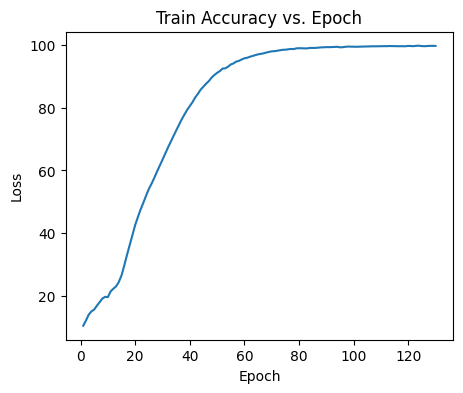

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(epochs,losses,predictions=None):
  plt.figure(figsize=(5,4))
  plt.plot(epochs, losses)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Train Accuracy vs. Epoch')
  plt.show()
plot_predictions(epoch_count,train_acc)

In [42]:
characters = string.ascii_uppercase + string.digits
idx_to_char = {idx: char for idx, char in enumerate(characters)}
def to_text(arr):
    ans=''
    for c in arr:
        ans=ans+idx_to_char[c.item()]
    return ans


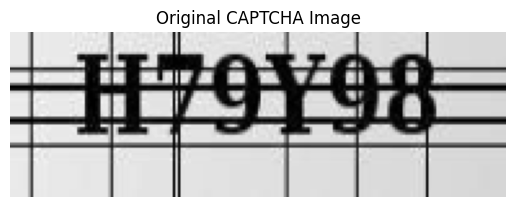

tensor([[ 7, 33, 35, 24, 35, 34]], device='cuda:0')
True : H79Y98
Pred : H79Y98


In [43]:
from itertools import groupby

characters = string.ascii_uppercase + string.digits
idx_to_char = {idx: char for idx, char in enumerate(characters)}
def to_text(arr):
    ans=''
    for c in arr:
        ans=ans+idx_to_char[c.item()]
    return ans

import matplotlib.pyplot as plt

model.eval()  # Set to eval mode

with torch.no_grad():
    for X, y in train_loader:
        # Select one sample
        X_single = X[0]
        y_single = y[0]

        # Show original image
        plt.imshow(X_single.numpy().squeeze(), cmap='gray')
        plt.title("Original CAPTCHA Image")
        plt.axis("off")
        plt.show()

        # Model output
        input_tensor = X_single.unsqueeze(0).to(device)
        output = model(input_tensor)  # [W, B, VOCAB_SIZE]
        output = F.log_softmax(output, dim=2)
        pred = output.argmax(dim=2).squeeze(1)  # [W]
        print(pred)
        # Decode prediction
        pred_text=''
        for i in pred:
            pred_text+= to_text(i)
        true_text = ''.join([idx_to_char[c.item()] for c in y_single if c.item() != -1])

        print(f"True : {true_text}")
        print(f"Pred : {pred_text}")
        break

In [ ]:
# 1. Instantiate the model
loaded_model = CaptchaCrackNet() 

# 2. Load the state dictionary
#Replace 'final.pth' or '10.pth' with your actual saved file name
state_dict = torch.load('final.pth', map_location=torch.device('cpu')) # you may need map_location=torch.device('cpu')

# 3. Load the state dictionary into the model
loaded_model.load_state_dict(state_dict) 

# Set the model to evaluation mode
loaded_model.eval()